In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2024-04-11 04:06:37.006013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 04:06:37.764357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('/home/kdt-admin/cleaned_data.csv').dropna(axis=0)

In [3]:
plt.rc('font', family='NanumBarunGothic')

In [4]:
df['문장'].nunique(), df['감정'].nunique()

(173247, 6)

In [5]:
df.drop_duplicates(subset=['문장'], inplace=True)
df.reset_index(drop=True, inplace=True)

<Axes: xlabel='감정'>

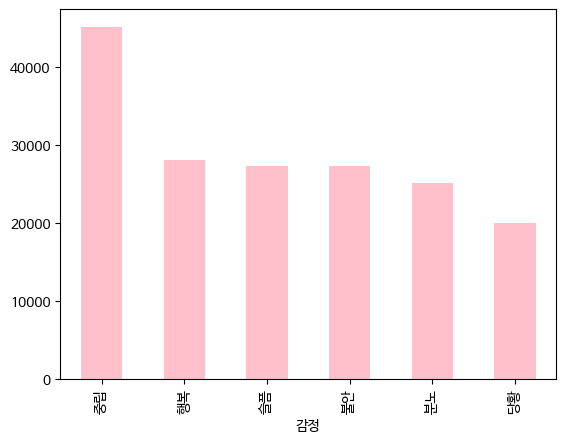

In [6]:
df['감정'].value_counts().plot(kind = 'bar', color= 'pink')

In [7]:
print(df.isnull().sum())

감정    0
문장    0
dtype: int64


In [8]:
print(df.isnull().values.any())

False


In [11]:
#HTML 태그 제거 함수
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

#이모지 및 특수 문자 제거 함수
def remove_noise(text):
    # 이모지 제거
    text = re.sub(r'[^\w\sㄱ-ㅎㅏ-ㅣ가-힣]', '', text)
    return text

#'문장' 열에 함수 적용
df['문장'] = df['문장'].apply(remove_html_tags)
df['문장'] = df['문장'].apply(remove_noise)
df[:5]

,Unnamed: 0,감정,문장
0,0,분노,일은 왜 해도 해도 끝이 없을까 화가 난다그냥 내가 해결하는 게 나아 남들한테 부담...
1,1,분노,이번 달에 또 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나최대...
2,2,분노,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...
3,3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 데 정말 분하고 섭...
4,4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나상사인 나에게 먼저...


## 토큰화 (Mecab)

In [18]:
import MeCab

# Mecab 객체 생성
mecab = MeCab.Tagger()

# 불용어 리스트
stopwords = ['있', '하', '되', '보', '않', '없', '사람', '주', '갈', '때', '가', '지', '대하', '오', '말', '일', '그렇', '위하', '두', '말하', '알', '받', '못하', '또', '문제', '더', '사회', '많', '좋', '크', '따르', '나오', '가지', '만들', '지금', '생각하', '그러', '속', '집', '살', '모르', '자신', '내', '경우', '생각', '시간', '다시', '앞', '보이', '나', '어떻', '점', '싶', '말', '정도', '좀', '잘', '통하', '소리', '놓', '같', '너무', '친구', '안', '해']

# 감정에 필요한 품사들
emotion_pos = ['NNG', 'VV', 'VA', 'MAG', 'IC', 'VV+EC', 'VV+EP','VX']

In [19]:
# 문장에서 불용어를 제거하고 감정에 필요한 품사만 선택하는 함수
def extract_emotion_words(sentence):
    parsed = mecab.parse(sentence)
    words = [word.split('\t')[0] for word in parsed.split('\n')[:-2] if word.split('\t')[0] not in stopwords]
    pos_tags = [word.split('\t')[1].split(',')[0] for word in parsed.split('\n')[:-2] if word.split('\t')[0] not in stopwords]
    emotion_words = [words[i] for i in range(len(words)) if pos_tags[i] in emotion_pos]
    return emotion_words

In [20]:
df['문장'] = df['문장'].apply(extract_emotion_words)

In [20]:
a = extract_emotion_words("아이고 허리야 물 좀 가져와봐라 ㅋㅋㅋㅋ ㅎㅎㅎ ㅣㅣㅣ ㅔㅔㅔ dddf ㅎㅎ")
a

['아이고', '허리', '물', '가져와', 'ㅋㅋ', 'ㅋㅋ', 'ㅎㅎㅎ', 'ㅣ', 'ㅣ', 'ㅣ', 'ㅎㅎ']

In [12]:
df['문장'][range(0,99)]

0     일은 왜 해도 해도 끝이 없을까 ? 화가 난다 . 그냥 내가 해결하는 게 나아 . ...
1     이번 달에 또 급여가 깎였어 ! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나...
2     회사에 신입이 들어왔는데 말투가 거슬려 . 그런 애를 매일 봐야 한다고 생각하니까 ...
3     직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 . 일도 많은 데 정말 분하고...
4     얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나 . 상사인 나에게...
                            ...                        
94    결혼 삼 년 차인데 아내가 매일같이 잔소리만 해 . 내가 아내랑 사는 것인지 엄마랑...
95    결혼 준비하면서 참 행복했는데 날짜가 다가올수록 초조해지고 불안해져 . 막연한 두려...
96    결혼이 코앞인데 아직 확신이 들지 않아 . 자꾸 도망치려는 내가 싫어져 . 여자친구...
97    결혼하고 아이가 생기면 좋을 줄 알았는데 그런 건 아무것도 없었어 . 집에 들어가면...
98    결혼하려고 하는데 친구랑 비교가 되네 . 비슷한 시기에 결혼하거든 . 근데 준비 과...
Name: 문장, Length: 99, dtype: object

In [22]:
# '문장' 열에서 가장 긴 문장 확인
longest_sentence = df.loc[df['문장'].apply(lambda x: len(x)).idxmax(), '문장']
print("가장 긴 문장:", longest_sentence)


가장 긴 문장: ['쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기']


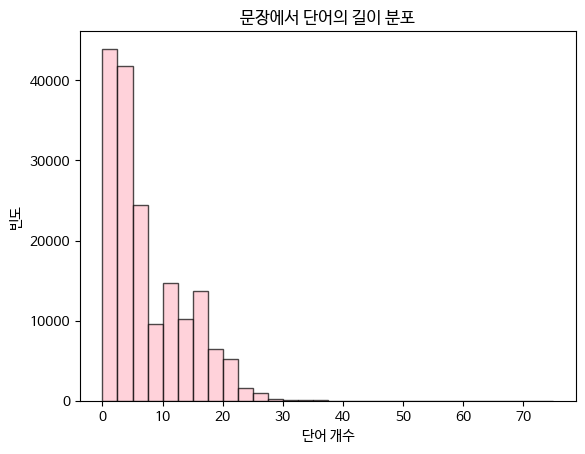

In [23]:
# '문장' 열에서 각 문장의 단어 개수 계산
word_lengths = [len(sentence) for sentence in df['문장']]

# 히스토그램으로 단어의 길이 시각화
plt.hist(word_lengths, bins=30, alpha=0.7, color='pink', edgecolor='black')
plt.xlabel('단어 개수')
plt.ylabel('빈도')
plt.title('문장에서 단어의 길이 분포')
plt.show()


In [21]:
# 토크나이저 객체 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['문장'])  # 텍스트 데이터에 대해 토큰화 및 정수 인코딩 수행

# 각 단어에 대한 고유한 정수 매핑
word_index = tokenizer.word_index

# 문장을 정수 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(df['문장'])

# 시퀀스의 길이를 맞추기 위한 패딩 추가
max_length = 30  # 패딩을 위한 최대 길이 지정
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# 결과 확인
print(padded_sequences)

[[   9  140  140 ...    0    0    0]
 [  43   81 1493 ...    0    0    0]
 [  22  646 1051 ...    0    0    0]
 ...
 [2202    0    0 ...    0    0    0]
 [   2  219    0 ...    0    0    0]
 [ 127   77    0 ...    0    0    0]]


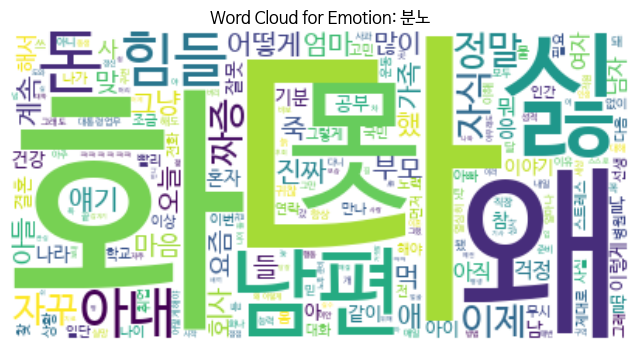

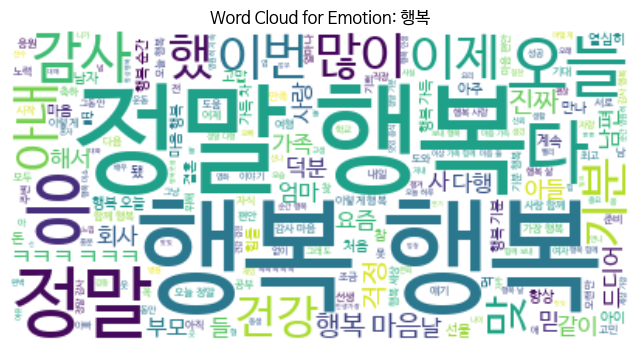

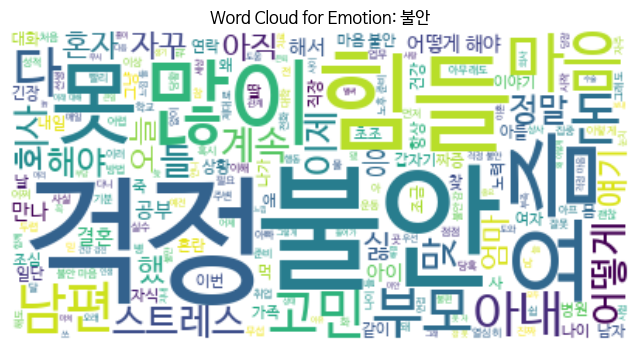

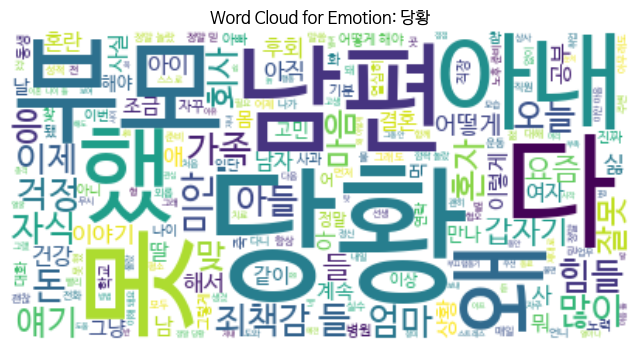

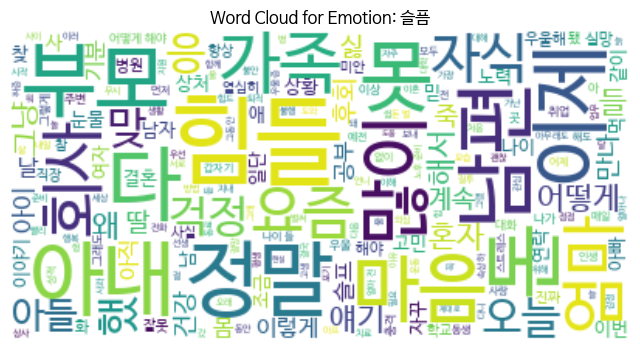

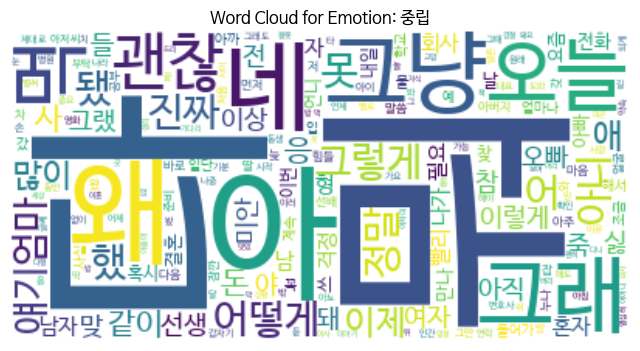

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 각각의 감정에 해당하는 문장을 모아서 딕셔너리에 저장
emotion_sentences = {}
for emotion in df['감정'].unique():
    emotion_sentences[emotion] = ' '.join([' '.join(sentence) for sentence in df[df['감정'] == emotion]['문장']])

# 감정별 워드클라우드 생성
for emotion, sentences in emotion_sentences.items():
    wordcloud = WordCloud(font_path=font_path, background_color='white').generate(sentences)

    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Emotion: {emotion}')
    plt.axis('off')
    plt.show()



In [152]:
# 단어별 빈도수 확인
word_counts = tokenizer.word_counts

# 빈도수를 기준으로 내림차순 정렬
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# 결과 출력
for word, count in sorted_word_counts:
    print(f'{word}: {count}')

못: 9994
다: 9715
들: 8572
돈: 8003
정말: 7711
왜: 6978
많이: 6867
먹: 6866
했: 6529
힘들: 6438
걱정: 6375
마음: 6238
이제: 5966
부모: 5927
어떻게: 5844
남편: 5748
회사: 5628
아내: 5628
오늘: 5392
엄마: 5032
건강: 4938
해서: 4881
응: 4857
요즘: 4675
가족: 4519
얘기: 4468
기분: 4381
자식: 4318
해야: 4251
공부: 4244
맞: 4152
열심히: 4118
결혼: 4043
싫: 4018
나이: 3983
사: 3959
그냥: 3939
혼자: 3909
화: 3850
이번: 3834
준비: 3654
애: 3619
이렇게: 3590
같이: 3579
뭐: 3578
아들: 3484
아: 3483
아직: 3439
학교: 3421
아이: 3327
이야기: 3305
몸: 3286
남자: 3249
만나: 3239
날: 3224
계속: 3170
남: 3160
여자: 3133
진짜: 3108
죽: 3093
고민: 3005
선생: 2984
대화: 2981
자꾸: 2967
미안: 2933
직장: 2882
병원: 2878
전: 2825
불안: 2768
아빠: 2738
딸: 2703
찾: 2581
취업: 2521
연락: 2512
잘못: 2492
참: 2481
달: 2447
나가: 2442
조금: 2439
그렇게: 2417
노력: 2392
됐: 2344
운동: 2302
짜증: 2181
믿: 2161
스트레스: 2121
먼저: 2117
돼: 2075
쓰: 2062
그래: 2061
상황: 2043
생활: 2031
성적: 2025
다니: 2023
일단: 1986
전화: 1978
후회: 1954
이상: 1949
괜찮: 1929
어: 1918
항상: 1912
노후: 1874
당황: 1873
사실: 1849
병: 1834
도움: 1826
갑자기: 1824
빨리: 1817
없이: 1785
술: 1754
시험: 1749
내일: 1733
필요: 1730
말씀: 16